In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [2]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# BYMARKEDER
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")

# KOMMUNEMARKEDER
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_full_l%C3%A6s%C3%B8.csv")

df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
df

,Kommune,by,By_befolkning,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,yderkom,År,antal_apo
0,101,København,528208,35.67,0.10,0.17,195272.57,0.53,0.70,0.78,539542,1564751.11,0,2010,17
1,147,Frederiksberg,100115,39.06,0.16,0.17,222330.66,0.52,0.74,0.84,98782,1783339.80,0,2010,5
2,230,Rudersdal,40199,41.74,0.21,0.24,269124.85,0.48,0.78,0.90,54765,2904041.88,0,2010,3
3,240,Ølstykke-Stenløse,23556,38.39,0.15,0.27,223787.65,0.52,0.83,0.94,41614,1461145.92,0,2010,1
4,240,Veksø,1891,38.39,0.15,0.27,223787.65,0.52,0.83,0.94,41614,1461145.92,0,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,820,Løgstør,4112,43.50,0.23,0.20,166023.23,0.49,0.76,0.91,37121,960791.40,0,2018,1
3497,183,Ishøj,22058,38.48,0.16,0.22,169250.18,0.48,0.72,0.60,22946,1459692.96,0,2018,1
3498,155,Søvang,13837,43.83,0.24,0.23,245042.36,0.49,0.83,0.92,14270,2653095.42,0,2018,1
3499,607,Fredericia,44394,42.01,0.21,0.20,184063.49,0.48,0.74,0.89,51427,1225318.90,0,2018,6


In [5]:
# df['Befolkning'] betyder at det er på kommuneniveau - er det korrekt?
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, 0 ,0 ,0]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [6]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [7]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

C:\Users\Oliver\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [8]:
# KOMMUNER
#df['logbefolkning'] = df['Befolkning']/1000#df['By_befolkning']/1000

# BYMARKEDER
df['logbefolkning'] = df['By_befolkning']/1000#


###
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

# Unrestricted markets
#df = df[df['restriction']==True]

In [9]:
# for 3 alpha 3 gamma
def V(df, Ni, alpha=np.ones(3), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([3, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log() 

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(3)):
    n = np.min([3, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[3]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S

#def neg_log_lik(theta=np.ones(19), market='TIRE', df=None):
def neg_log_lik(theta=np.ones(15), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:10]
    gamma = theta[10:14]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 4
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[3] = np.log( Phi(Pi_bar(3)) )
    for i in range(1,3):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(4):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(3):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[3] * (df[market] >= 3))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:10]
    gamma = theta[10:14]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [10]:
theta0 = np.ones(14) * 0.1
neg_log_lik(df=df, theta=theta0)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


6090.751848545434

In [11]:
df = df.sample(frac=1, random_state = 1).reset_index(drop=True)

In [12]:
%%time
ba = [-np.inf] * 7
bb = [0] * 6
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 14
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(14) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


Wall time: 52.9 s


In [13]:
out

      fun: 2111.4902639037527
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.66255631e-01, -1.17506715e-01, -8.68567440e-02, -2.85490387e-01,
       -6.28006092e-02, -5.62022251e-01,  5.33418643e-02,  5.85187991e+01,
       -1.72076398e-01,  5.66888048e-01, -2.78168955e-01,  1.17734089e-01,
        1.54341251e-01, -1.16506271e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4695
      nit: 270
   status: 0
  success: True
        x: array([ 0.70814875,  0.98582662, -1.3863177 , -0.08402569,  0.63709004,
        0.1804512 , -0.01727791,  0.        ,  0.20071438,  0.05400003,
        0.96948584,  2.04439095,  0.47949302,  0.00774859])

In [14]:
N = len(df) #Korriger så det passer til antal observationer. 
test = out.hess_inv.todense()/N
se3 = np.sqrt(np.diag(test))
se3

array([0.01901789, 0.45674421, 0.49625845, 0.02377796, 0.04269057,
       0.1261734 , 0.04398601, 0.01690067, 0.0472784 , 0.01571541,
       0.03918905, 0.21572632, 0.41213609, 0.0213076 ])

In [15]:
Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'],'std err':se, "std err diag":se3})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom', 'alpha_1','alpha_2','alpha_3','gamma_1','gamma_2','gamma_3', 'gamma_6 - Landvalue'] #,'gamma6'  
results

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


,parameters,std err,std err diag
lambda - befolkning,0.71,0.08,0.02
beta_1 - d65,0.99,0.14,0.46
beta_2 - d17,-1.39,0.24,0.50
beta_3 - indkomst,-0.08,nan,0.02
beta_4 - besk,0.64,0.06,0.04
beta_5 - Foreigner,0.18,0.05,0.13
beta_6 - yderkom,-0.02,0.02,0.04
alpha_1,0.00,0.06,0.02
alpha_2,0.20,0.03,0.05
alpha_3,0.05,0.01,0.02


In [16]:
hat_theta = theta_to_param_dict(out.x)

In [17]:
hat_theta

{'lam': 0.7081487541422691,
 'beta': array([ 0.98582662, -1.3863177 , -0.08402569,  0.63709004,  0.1804512 ,
        -0.01727791]),
 'alpha': array([0.        , 0.20071438, 0.05400003]),
 'gamma': array([0.96948584, 2.04439095, 0.47949302, 0.00774859]),
 'theta': array([ 0.70814875,  0.98582662, -1.3863177 , -0.08402569,  0.63709004,
         0.1804512 , -0.01727791,  0.        ,  0.20071438,  0.05400003,
         0.96948584,  2.04439095,  0.47949302,  0.00774859])}

In [18]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

1.064327142996905
[0.39204587]
3.1087180970277735
[0.19133149]
3.58821111456284
[0.13733145]
3.58821111456284
[0.13733145]
3.58821111456284
[0.13733145]


In [19]:
S_vals

array([ 2.71480257, 16.24781222, 26.12810844, 26.12810844, 26.12810844])

In [20]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,2.71,16.25,26.13,26.13,26.13


In [21]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,2.99,1.07,0.75,0.80


In [22]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [23]:
SN_S5_ratio 

array([1.92486251, 0.64324004, 0.6       , 0.8       , 1.        ])

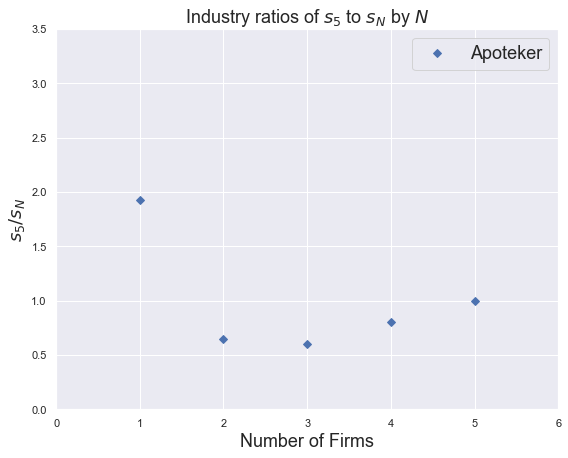

In [24]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.0, 3.5)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)